# Callbacks in torchbearer

This guide will give a detailed introduction to callbacks in torchbearer. We'll start with the basics, before going in to some more advanced use cases.

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. You won't need a GPU for these examples.

## Install Torchbearer

First we install torchbearer if needed. 

In [1]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
print(torchbearer.__version__)

0.3.2


## The Callback Class

In torchbearer, callbacks are any object which extends / implements [`Callback`](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#torchbearer.bases.Callback). These objects have methods which are each called at different points during the training process. Here's the list:

In [2]:
from torchbearer import Callback

print([method for method in dir(Callback) if str.startswith(method, 'on')])

['on_backward', 'on_checkpoint', 'on_criterion', 'on_criterion_validation', 'on_end', 'on_end_epoch', 'on_end_training', 'on_end_validation', 'on_forward', 'on_forward_validation', 'on_init', 'on_sample', 'on_sample_validation', 'on_start', 'on_start_epoch', 'on_start_training', 'on_start_validation', 'on_step_training', 'on_step_validation']


If we want to know more about one of the callback points, we can look in [the docs](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#torchbearer.bases.Callback), or just use the help builtin.

In [3]:
help(Callback.on_backward)

Help on function on_backward in module torchbearer.bases:

on_backward(self, state)
    Perform some action with the given state as context after backward has been called on the loss.
    
    Args:
        state (dict): The current state dict of the :class:`.Trial`.



Callback points are functions of state. This is the state dictionary that sits at the heart of torchbearer. The contents of state change for each callback point and it can be modified with callbacks. This means that you can change or customise much of the functionality of torchbearer just using callbacks.

### Decorators

Often when using callbacks, we don't really want to deal with them as classes. Instead, we might want to just treat a callback as a function. We can do this using the [decorator API](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#decorators). These are decorators which let you use a function at a specific (or multiple specific) callback point(s). We'll see some uses of callback decorators in our third example.

### Callback State

Two methods we haven't covered are `state_dict` and `load_state_dict`. These are methods which can be used to serialise and restore the state of callback when the `Trial` is saved. Since state isn't persistent, everything in it needs to be reloaded whenever `run` is called or the `Trial` is reloaded. For that reason, any callback which needs persistence should implement `state_dict` and `load_state_dict`.

## Example: Contents of state

For our first example, lets create a quick callback which just tells us the keys that are in state

In [4]:
class KeyCache(Callback):
    def __init__(self):
        self.keys = {}
    
    def __getattribute__(self, name):
        if str.startswith(name, 'on'):
            def callback(state):
                self.keys[getattr(Callback, name)] = list(state.keys())
            return callback
        else:
            return super().__getattribute__(name)

To use our callback we create an empty `Trial` object. The only thing a trial needs to be run is a model, so we create an empty model to test. 

In [5]:
import torch.nn as nn

class EmptyModel(nn.Module):
    def forward(self, x):
        return None

from torchbearer import Trial

cache = KeyCache()
trial = Trial(EmptyModel(), callbacks=[cache]).for_train_steps(1)
_ = trial.run()

`for_train_steps(1)` in the above example tells the `Trial` to run one batch of training per epoch. Since we haven't provided any data, the model will be given `None` and since there is no loss function, the model outputs will be ignored. The `callbacks` argument takes a list of `Callback` objects, internally this uses the [`CallbackList` class](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#torchbearer.callbacks.callbacks.CallbackList).

Now that we have our dictionary, we can print the available state keys for different callback points. For example:

In [6]:
print(cache.keys[Callback.on_start_epoch])

[max_epochs, stop_training, model, criterion, optimizer, metric_list, callback_list, device, dtype, self, history, backward_args, train_generator, validation_generator, test_generator, train_steps, validation_steps, test_steps, train_data, validation_data, test_data, inf_train_loading, epoch]


Each of these keys contains a value relating to the training process of the model. For example`*_generator` contain the data loaders that have been passed to the trial. The full list of these keys can be found [here](https://torchbearer.readthedocs.io/en/latest/code/main.html#module-torchbearer.state). They're printed as strings here, but state should be accessed with [`StateKey`](https://torchbearer.readthedocs.io/en/latest/code/main.html#torchbearer.state.StateKey) objects to prevent collisions. For example, `device` becomes `torchbearer.DEVICE`.

## Example: Call Order

In this example, we'll create a quick logging callback that we can use to show the order that each callback function is triggered. We could also use something like this to check which parts of our training process take the most time. We first define and run our callback. **Note** that we use a validation and test step here aswell to see all of the callbacks.

In [7]:
import torchbearer
import time

class Timer(Callback):
    def __init__(self):
        self.names = []
        self.times = []
        
        self.t0 = time.time()
    
    def __getattribute__(self, name):
        if str.startswith(name, 'on'):
            def callback(state):
                self.names.append(name)
                self.times.append(time.time() - self.t0)
                # Sleep a bit to prevent the callbacks bunching up, remove this line for accurate timing
                time.sleep(0.01)
            return callback
        else:
            return super().__getattribute__(name)
        
import torch.nn as nn

class EmptyModel(nn.Module):
    def forward(self, x):
        return None

from torchbearer import Trial

timer = Timer()
trial = Trial(EmptyModel(), callbacks=[timer], verbose=1).for_steps(1, 1, 1)
_ = trial.run()
_ = trial.evaluate(data_key=torchbearer.TEST_DATA)

And now with a bit of matplotlib (largely stolen from [here](https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/timeline.html)), we can see the order that each callback point was triggered.

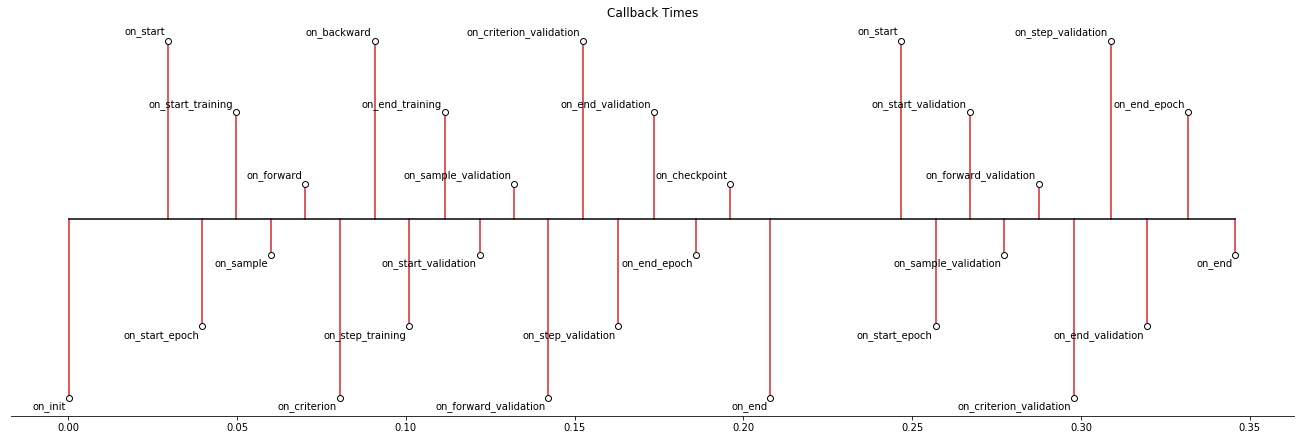

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(timer.times)/6)))[:len(timer.times)]

fig, ax = plt.subplots(figsize=(18, 6), constrained_layout=True)
ax.set(title="Callback Times")
markerline, stemline, baseline = ax.stem(timer.times, levels,
                                         linefmt="C3-", basefmt="k-")

plt.setp(markerline, mec="k", mfc="w", zorder=3)

vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for d, l, r, va in zip(timer.times, levels, timer.names, vert):
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="right")

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

plt.show()
fig.savefig('timeline.png')

From the graph we can see that most callback points will get called multiple times during the life of a `Trial`. The only callback which gets called once is `on_init`. Incidentally, `on_init` is also the only callback which can mutate the root level `Trial` state. That is, anything you put in state here will be present in every call to `run` or `evaluate`.  

## Example: Decorators

In this example, we have a look at some of the powerful things you can do with callback decorators in torchbearer. These are decorators which can turn a function of state into a callback at a specific point. For example, suppose we want to run something on forward during training and validation, we can do the following:

In [9]:
from torchbearer import callbacks

@callbacks.on_forward
@callbacks.on_forward_validation
def my_callback(state):
    print('Should be printed twice')

import torch.nn as nn

class EmptyModel(nn.Module):
    def forward(self, x):
        return None

from torchbearer import Trial

trial = Trial(EmptyModel(), callbacks=[my_callback], verbose=1).for_steps(1, 1)
_ = trial.run()

Should be printed twice
Should be printed twice



You can chain as many of the decorators as required, and there is one for each of the callback points.

### Advanced Decorators

Sometimes you want a bit more power than you get with just a simple callback point. In that case you can use some of the advanced decorators in torchbearer. These are: [`add_to_loss`](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#torchbearer.callbacks.decorators.add_to_loss), [`once`](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#torchbearer.callbacks.decorators.once), [`once_per_epoch`](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#torchbearer.callbacks.decorators.once_per_epoch) and [`only_if`](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#torchbearer.callbacks.decorators.only_if). Let's have a look at them in more detail

#### `add_to_loss`

The add to loss decorator is used to add the result of a function to the loss at the end of each step. This is useful if you have a loss that is made up of multiple terms (e.g. when training VAEs) that you would like to treat seperately. In this example, we just add a number to the loss each time.

In [10]:
import torch
import torchbearer
from torchbearer import callbacks

@callbacks.add_to_loss  # ADD TO LOSS
def my_callback(state):
    return torch.ones(1) * 10

@callbacks.on_step_training
def print_loss(state):
    print(state[torchbearer.LOSS])
    
import torch.nn as nn

class EmptyModel(nn.Module):
    def forward(self, x):
        return None

from torchbearer import Trial

trial = Trial(EmptyModel(), callbacks=[my_callback, print_loss], verbose=1).for_steps(1, 1)
_ = trial.run()

tensor([10.], grad_fn=<AddBackward0>)



#### `once` and `once_per_epoch`

The once and once per epoch decorators are used to call a function either once ever, or once each epoch respectively. For these, you need to also use one of the other decorators to tell it *when* to run the callback. They don't persist, so use a `once` callback the same way you would use something like `on_init`.

In [11]:
import torch
import torchbearer
from torchbearer import callbacks

@callbacks.once  # ONCE
@callbacks.on_step_training
def print_once(state):
    print('once')

@callbacks.once_per_epoch  # ONCE PER EPOCH
@callbacks.on_step_training
def print_once_per_epoch(state):
    print('once per epoch')
    
import torch.nn as nn

class EmptyModel(nn.Module):
    def forward(self, x):
        return None

from torchbearer import Trial

trial = Trial(EmptyModel(), callbacks=[print_once, print_once_per_epoch], verbose=1).for_steps(1, 1)
_ = trial.run(3)

once
once per epoch
once per epoch
once per epoch



#### `only_if`

The final advanced decorator is `only_if`, this will run the callback **only** if the given predicate (a function of state) is `True`. Here's an example:

In [12]:
import torch
import torchbearer
from torchbearer import callbacks

PIGS = torchbearer.state_key('pigs')

@callbacks.on_sample
def step(state):
    if state[torchbearer.BATCH] % 3 == 0:
        state[PIGS] = 'fly'
    else:
        state[PIGS] = 'walk'

@callbacks.only_if(lambda state: state[PIGS] == 'fly')  # ONLY IF
@callbacks.on_step_training
def check(state):
    print('Oink!')
    
import torch.nn as nn

class EmptyModel(nn.Module):
    def forward(self, x):
        return None

from torchbearer import Trial

trial = Trial(EmptyModel(), callbacks=[step, check], verbose=1).for_train_steps(18)
_ = trial.run(1)

Oink!
Oink!
Oink!
Oink!
Oink!
Oink!



That's about everything there is to know about callbacks in torchbearer, have a look at the other notebooks for some examples of how callbacks can be used in practice. We also haven't touched on all of the callbacks that are included with torchbearer, to learn about those have a look at the docs pages [here](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#).